# RealNVP (*In progress*)

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**
- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184?keywords=generative+deep+learning,+2nd+edition&qid=1684708209&sprefix=generative+de,aps,93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/06_normflow/01_realnvp/realnvp.ipynb)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as sk_datasets

import torch
from torch import nn
from torch import distributions

import torchinfo

## 0. Training Parameters

In [2]:
NUM_SAMPLES = 30_000
COULPING_LAYERS = 2
INPUT_DIM = 2
HIDDEN_DIM = 256
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

## 1. Preparing Moon dataset

The shape of moon dataset (30000, 2)


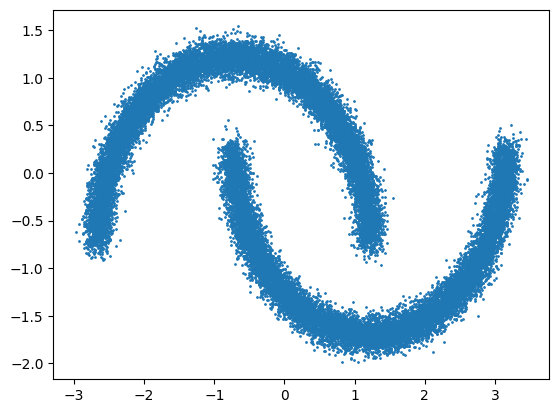

In [3]:
data = sk_datasets.make_moons(NUM_SAMPLES, noise=5e-2)[0].astype("float32")
print("The shape of moon dataset", data.shape)
# data normalization
mean = data.mean()
std = data.std()
data = (data - mean) / (std ** 2)
# visualize data
plt.scatter(data[:, 0], data[:, 1], s=1.0)
plt.show()

## 2. Building RealNVP

Building backbone layer

In [4]:
def get_backbone_layer(n_layers=5, output_activation=nn.Tanh):
    dims = [INPUT_DIM] + [HIDDEN_DIM] * (n_layers - 1) + [INPUT_DIM]
    layers = []
    for i in range(n_layers):
        layers.append(nn.Linear(dims[i], dims[i+1]))
        if i != n_layers - 1: 
            layers.append(nn.ReLU())
        else:
            layers.append(output_activation())
    return nn.Sequential(*layers)

In [5]:
torchinfo.summary(get_backbone_layer(), input=(1, 2))

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            768
├─ReLU: 1-2                              --
├─Linear: 1-3                            65,792
├─ReLU: 1-4                              --
├─Linear: 1-5                            65,792
├─ReLU: 1-6                              --
├─Linear: 1-7                            65,792
├─ReLU: 1-8                              --
├─Linear: 1-9                            514
├─Tanh: 1-10                             --
Total params: 198,658
Trainable params: 198,658
Non-trainable params: 0

Implement RealNVP model

In [29]:
class RealNVP(nn.Module):

    num_couplings = COULPING_LAYERS
    
    def __init__(self):
        super().__init__()
        self.distribution = distributions.MultivariateNormal(loc = torch.zeros(2), 
                                                             covariance_matrix= torch.eye(2))
        self.mask = torch.tensor([[0, 1], [1, 0]] * (self.num_couplings // 2), dtype=torch.float32)

        self.t = nn.ModuleList([get_backbone_layer(output_activation=nn.Identity)
                                for _ in range(self.num_couplings)])
        self.s = nn.ModuleList([get_backbone_layer(output_activation=nn.Tanh)
                                for _ in range(self.num_couplings)])


    # f(x) forward process
    def f(self, x):
        log_det_inv = torch.zeros_like(x)
        z = x
        for i in reversed(range(len(self.t))):
            z_masked = self.mask[i] * z
            s = self.s[i](z_masked) * (1 - self.mask[i])
            t = self.t[i](z_masked) * (1 - self.mask[i])
            z = z_masked + (1 - self.mask[i]) * (z - t) * torch.exp(-s)
            log_det_inv -= s.sum(dim=1)
        return z, log_det_inv

    # g(z) backward process
    @torch.no_grad()
    def g(self, z):
        x = z
        for i in range(len(self.s)):
            x_masked = self.mask[i] * x
            s = self.s[i](x_masked) * (1 - self.mask[i])
            t = self.t[i](x_masked) * (1 - self.mask[i])
            x = x_masked + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def forward(self, data=None, num_samples=None):
        if self.training:
            assert data is not None, "Training data should be provided" 
            print("Training mode")
            z, log_det = self.f(data)
            return self.distribution.log_prob(z) + log_det
        else:
            assert num_samples is not None, "Number of samples should be provided"
            print("Inferencing mode")
            z = self.prior.sample((num_samples, 1))
            x = self.g(z)
            return x